In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

pd.set_option('display.max_columns', None)
sns.set_theme(style='whitegrid', rc={'figure.dpi': 120})


In [ ]:
DATA_PATH = Path('mental_health_dataset.csv')  
df = pd.read_csv(DATA_PATH)
print(f'Dataset shape: {df.shape}')
df.head()


Dataset shape: (10000, 14)


,age,gender,employment_status,work_environment,mental_health_history,seeks_treatment,stress_level,sleep_hours,physical_activity_days,depression_score,anxiety_score,social_support_score,productivity_score,mental_health_risk
0,56,Male,Employed,On-site,Yes,Yes,6,6.2,3,28,17,54,59.7,High
1,46,Female,Student,On-site,No,Yes,10,9.0,4,30,11,85,54.9,High
2,32,Female,Employed,On-site,Yes,No,7,7.7,2,24,7,62,61.3,Medium
3,60,Non-binary,Self-employed,On-site,No,No,4,4.5,4,6,0,95,97.0,Low
4,25,Female,Self-employed,On-site,Yes,Yes,3,5.4,0,24,12,70,69.0,High


### Basic information


In [3]:
df.info()
df.describe(include='all').T.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   age                     10000 non-null  int64  
 1   gender                  10000 non-null  object 
 2   employment_status       10000 non-null  object 
 3   work_environment        10000 non-null  object 
 4   mental_health_history   10000 non-null  object 
 5   seeks_treatment         10000 non-null  object 
 6   stress_level            10000 non-null  int64  
 7   sleep_hours             10000 non-null  float64
 8   physical_activity_days  10000 non-null  int64  
 9   depression_score        10000 non-null  int64  
 10  anxiety_score           10000 non-null  int64  
 11  social_support_score    10000 non-null  int64  
 12  productivity_score      10000 non-null  float64
 13  mental_health_risk      10000 non-null  object 
dtypes: float64(2), int64(6), object(6)
memo

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
age,10000.0,NaN,NaN,NaN,41.5576,13.749581,18.0,30.0,41.5,53.0,65.0
gender,10000,4,Male,4557,NaN,NaN,NaN,NaN,NaN,NaN,NaN
employment_status,10000,4,Employed,5868,NaN,NaN,NaN,NaN,NaN,NaN,NaN
work_environment,10000,3,On-site,5044,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mental_health_history,10000,2,No,6969,NaN,NaN,NaN,NaN,NaN,NaN,NaN


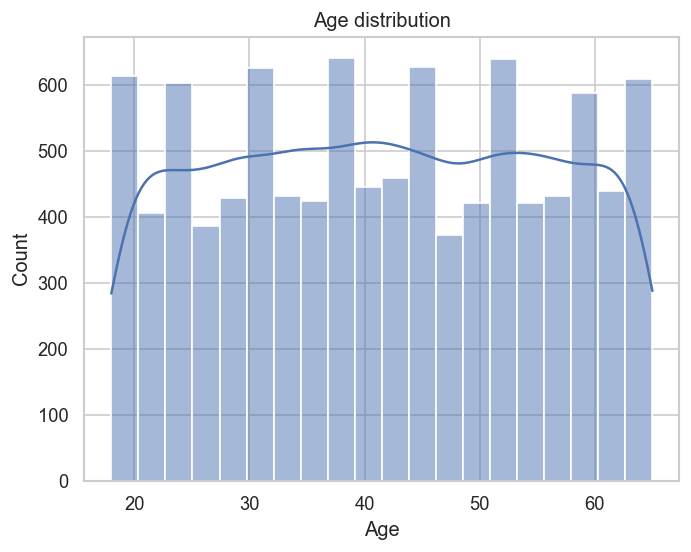

In [4]:
plt.figure()
sns.histplot(df['age'], bins=20, kde=True)
plt.title('Age distribution')
plt.xlabel('Age')
plt.show()


/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8209 (\N{NON-BREAKING HYPHEN}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


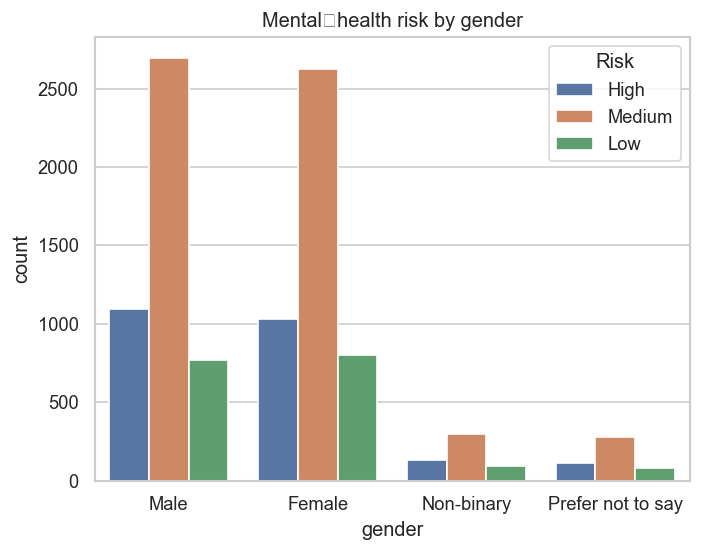

In [5]:
plt.figure()
sns.countplot(data=df, x='gender', hue='mental_health_risk')
plt.title('Mental‑health risk by gender')
plt.legend(title='Risk')
plt.show()


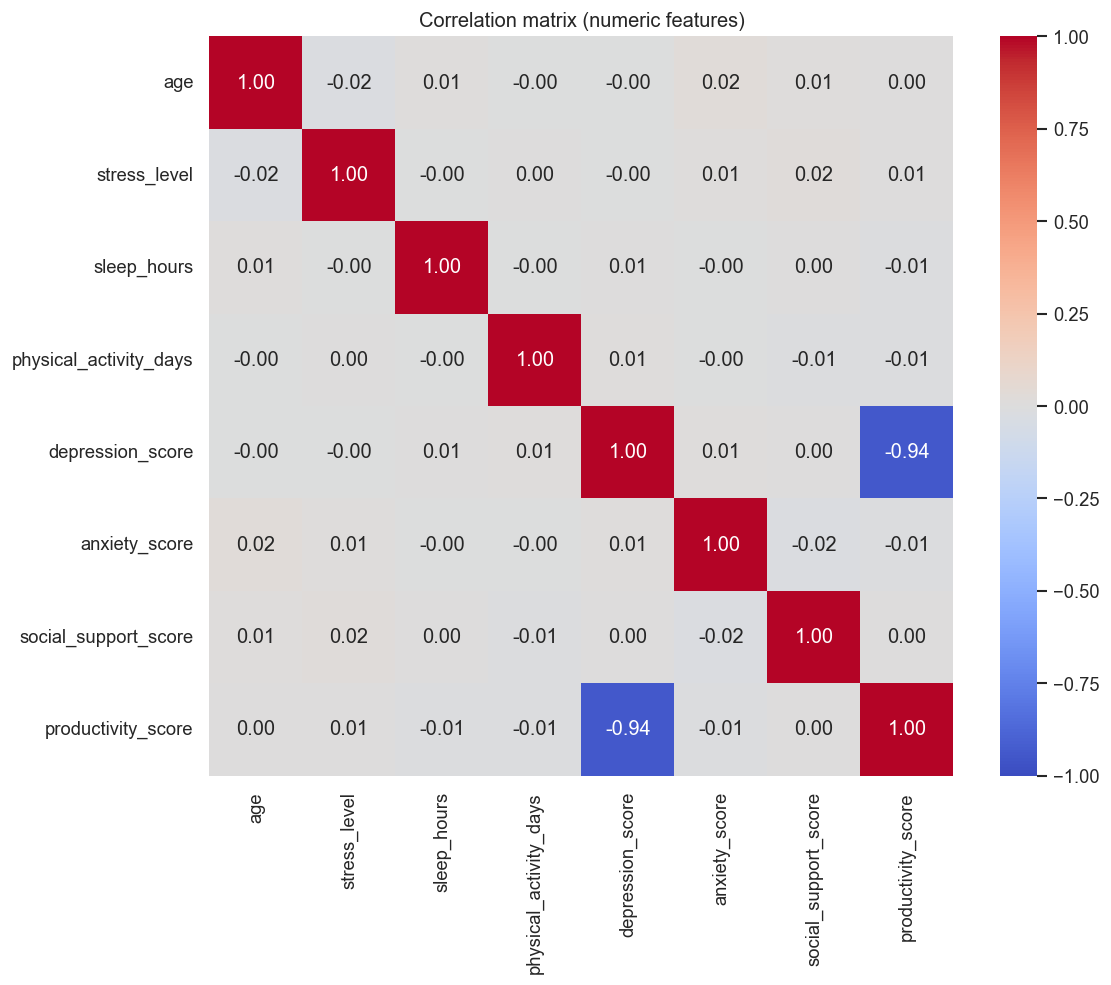

In [6]:
numeric_cols = df.select_dtypes(include='number').columns
plt.figure(figsize=(10,8))
corr = df[numeric_cols].corr()
sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation matrix (numeric features)')
plt.show()


In [7]:
target = 'mental_health_risk'
X = df.drop(columns=[target])
y = df[target]

# Train‑test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y)

# Column groups
num_cols  = X.select_dtypes(include='number').columns.tolist()
cat_cols  = X.select_dtypes(exclude='number').columns.tolist()

numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_cols),
        ('cat', categorical_transformer, cat_cols)
])


In [8]:
log_reg = Pipeline(steps=[
    ('preprocess', preprocessor),
    ('model',     LogisticRegression(max_iter=1000, multi_class='multinomial'))
])

log_reg.fit(X_train, y_train)
y_pred = log_reg.predict(X_test)
print('Baseline performance:')
print(classification_report(y_test, y_pred))


Baseline performance:
              precision    recall  f1-score   support

        High       1.00      1.00      1.00       474
         Low       1.00      1.00      1.00       348
      Medium       1.00      1.00      1.00      1178

    accuracy                           1.00      2000
   macro avg       1.00      1.00      1.00      2000
weighted avg       1.00      1.00      1.00      2000



/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


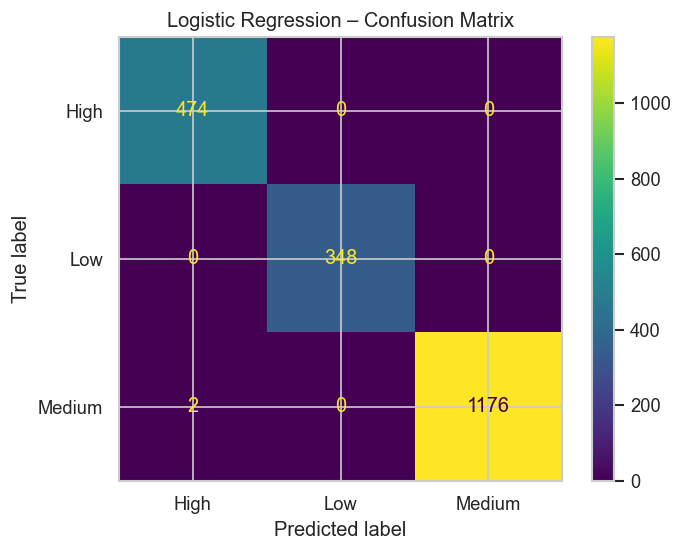

In [9]:
ConfusionMatrixDisplay.from_estimator(log_reg, X_test, y_test)
plt.title('Logistic Regression – Confusion Matrix')
plt.show()


Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best macro‑F1: 0.949
Best parameters: {'model__max_depth': None, 'model__min_samples_split': 2, 'model__n_estimators': 400}
Test‑set performance:
              precision    recall  f1-score   support

        High       0.98      0.95      0.96       474
         Low       0.99      0.91      0.94       348
      Medium       0.95      0.99      0.97      1178

    accuracy                           0.96      2000
   macro avg       0.97      0.95      0.96      2000
weighted avg       0.96      0.96      0.96      2000



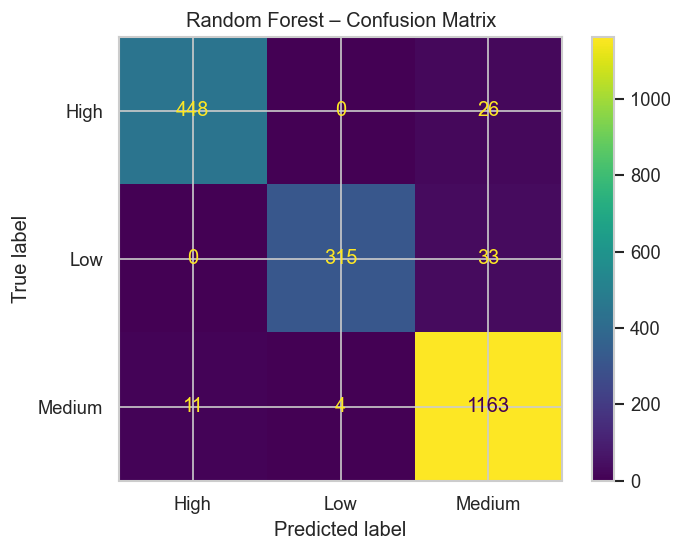

In [10]:
rf_clf = Pipeline(steps=[
    ('preprocess', preprocessor),
    ('model',     RandomForestClassifier(random_state=42))
])

param_grid = {
    'model__n_estimators': [200, 400],
    'model__max_depth': [None, 10, 20],
    'model__min_samples_split': [2, 5],
}

grid = GridSearchCV(rf_clf, param_grid, cv=5, scoring='f1_macro', n_jobs=-1, verbose=1)
grid.fit(X_train, y_train)

print(f'Best macro‑F1: {grid.best_score_:.3f}')
print('Best parameters:', grid.best_params_)

best_model = grid.best_estimator_

y_pred_best = best_model.predict(X_test)
print('Test‑set performance:')
print(classification_report(y_test, y_pred_best))
ConfusionMatrixDisplay.from_estimator(best_model, X_test, y_test)
plt.title('Random Forest – Confusion Matrix')
plt.show()


<Figure size 768x576 with 0 Axes>

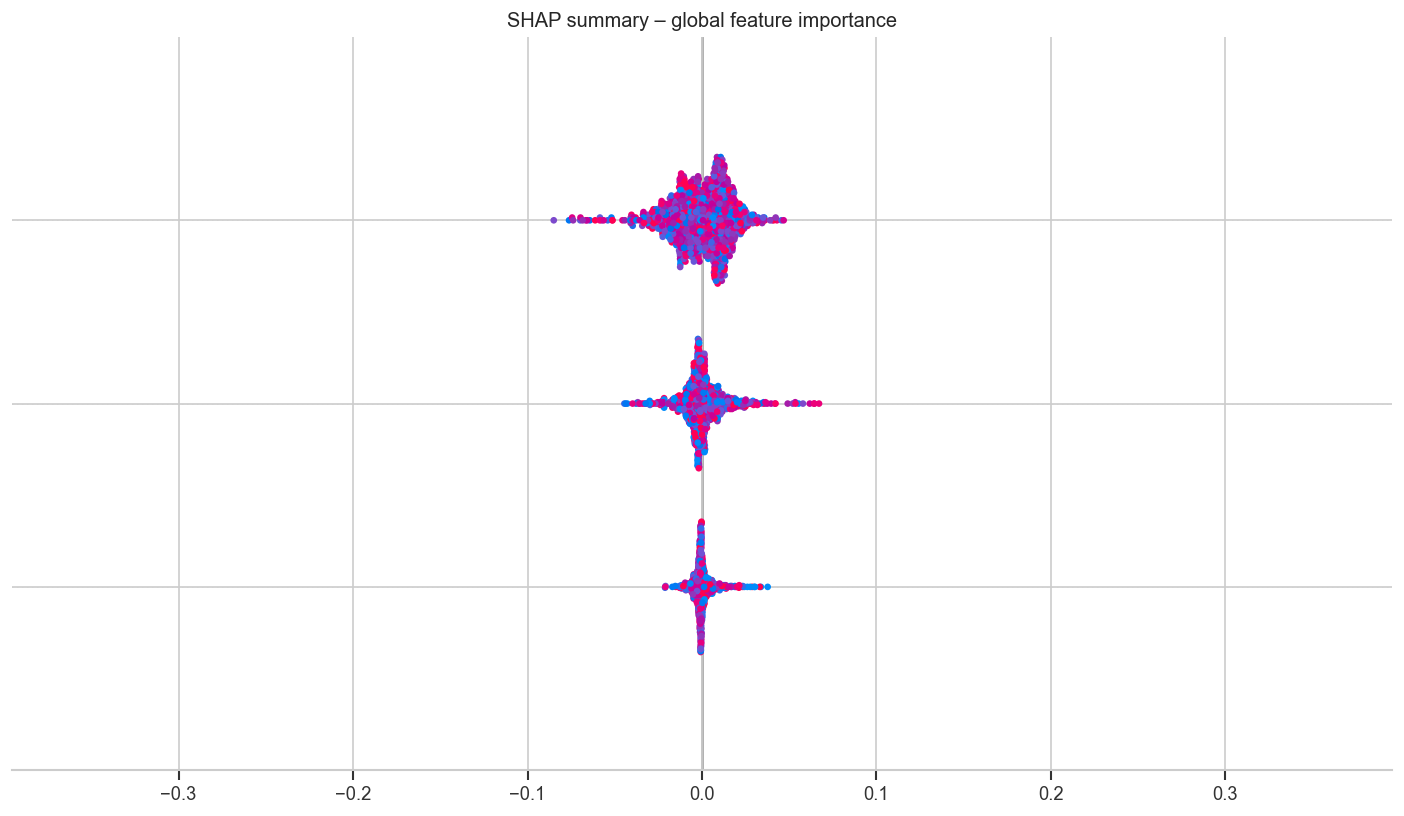

In [ ]:
import shap
X_sample = X_train.sample(min(1000, len(X_train)), random_state=42)

pre = best_model.named_steps['preprocess']
X_sample_trans = pre.transform(X_sample)

feature_names = pre.get_feature_names_out()
X_sample_trans = pd.DataFrame(X_sample_trans,
                              columns=feature_names,
                              index=X_sample.index)

explainer = shap.TreeExplainer(best_model.named_steps['model'])
shap_values = explainer.shap_values(X_sample_trans)

shap.summary_plot(shap_values, X_sample_trans, show=False)
plt.title("SHAP summary – global feature importance")
plt.show()
